In [4]:
import numpy
import time
import ipyparallel as ipp
from scipy import stats
from qiskit.aqua.operators.legacy import op_converter
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit.quantum_info import Pauli
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, CircuitStateFn 
import scipy
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.compiler import transpile
from qiskit.circuit.random import random_circuit
from qiskit.chemistry.components.variational_forms import UCCSD
from tqdm import tqdm
from qiskit.providers.aer import AerSimulator

In [5]:
import warnings
warnings. filterwarnings('ignore')

In [6]:
c = ipp.Client()
num_qubits=8

In [7]:
def qubitOp(h1,h2,Map):
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    mapper=ParityMapper() if Map=='parity' else JordanWignerMapper() 
    qubit_conv = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = qubit_conv.convert(fer_op, len(h1)//2)
    return qubit_op

In [8]:
def egBandHamiltonian(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
            = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2,Map='parity')
    Hmat=qubitH.to_matrix(massive=True)
    w,v=numpy.linalg.eigh(Hmat)
    Eg=w[0]
    state_g=v[:,0]
    return qubitH,Hmat,Eg,state_g

In [9]:
def HF_init_state(U):
    N=4
    # Qiskit implementation of Givens rotation
    def prepare_givens_rotated_state(givens):
        circ = QuantumCircuit(2*N)
        # Fill first N_f orbitals for each spin
        for i in range(N_f):
            circ.x(i)
            circ.x(i+N)
        for rots in givens:
            for tup in rots:
                #for spin down
                spin=0
                circ.cnot(tup[1]+N*spin,tup[0]+N*spin)
                circ.cry(-2*tup[2],tup[0]+N*spin, tup[1]+N*spin)
                circ.cnot(tup[1]+N*spin, tup[0]+N*spin)
                circ.rz(tup[3],tup[1]+N*spin)
                #for spin up
                spin=1
                circ.cnot(tup[1]+N*spin,tup[0]+N*spin)
                circ.cry(-2*tup[2],tup[0]+N*spin, tup[1]+N*spin)
                circ.cnot(tup[1]+N*spin, tup[0]+N*spin)
                circ.rz(tup[3],tup[1]+N*spin)
        final_state_vector=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()      
        return circ,final_state_vector
    def cost_fn(angles):
        givens=[((1, 2, angles[0], 0.0),), ((0, 1, angles[1], 0.0), (2, 3, angles[2], 0.0)), ((1, 2, angles[3], 0.0),)]  
        #c=Givens_rot_circuit(givens)
        #state = QuantumState(N*2)
        #c.update_quantum_state(state)
        #state_vector=numpy.array(state.get_vector())
        c,state=prepare_givens_rotated_state(givens)
        E=numpy.real(numpy.dot(numpy.dot(numpy.conjugate(state),Hmat),state))
        return E
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot        
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            eg_h2[i,j,k,l] = eg_h2[i+num_sites,j+num_sites,k,l] = eg_h2[i,j,k+num_sites,l+num_sites] \
            = eg_h2[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
    qubitH=qubitOp(eg_h1,eg_h2)
    Hmat=qubitH.to_matrix(massive=True)
    E,V=numpy.linalg.eigh(eg_h1)
    energy = 2*sum(E[:int(N/2)])
    psi = V[:,:int(N/2)]
    Q = numpy.transpose(numpy.conjugate(psi))
    N_f=len(Q)
    givens_init = slater_determinant_preparation_circuit(Q)
    params_init=[]
    for k in range(len(givens_init)):
        for l in range(len(givens_init[k])):
            params_init.append(givens_init[k][l][2])        
    res = scipy.optimize.minimize(cost_fn, params_init, bounds=[[-numpy.pi,numpy.pi]]*4,method='L-BFGS-B')
    print("Final Hartree Fock Energy",res['fun'])
    #final slater determinant state vector obtained using quantum variational Hartree Fock using Given Rotations
    params_fin=res['x']
    #Final Givens Rotation Circuit obtained after implementing L-BFGS-B algorithm
    givens_fin=[((1, 2, params_fin[0], 0.0),), ((0, 1, params_fin[1], 0.0), (2, 3, params_fin[2], 0.0)), ((1, 2, params_fin[3], 0.0),)]
    HFcirc,HFstateVec=prepare_givens_rotated_state(givens_fin)
    return HFcirc,HFstateVec

In [10]:
#One particle density matrix-statevector
def one_RDM(data):
    import numpy
    from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
    from qiskit_nature.mappers.second_quantization import JordanWignerMapper
    state,num_qubits,i,j=data
    mapper=JordanWignerMapper()
    h1=numpy.zeros((num_qubits,num_qubits))*1j
    h2=numpy.zeros((num_qubits,num_qubits))*1j
    h1[i,j]=h1[j,i]=0.5
    h2[i,j]=0.5*1j
    h2[j,i]=-0.5*1j
    h1=fermionic_op_builder.build_ferm_op_from_ints(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
    h2=fermionic_op_builder.build_ferm_op_from_ints(h2,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
    h1=mapper.map(h1)
    h2=mapper.map(h2)
    h1=h1.to_matrix(massive=True)
    h2=h2.to_matrix(massive=True)
    h=h1+1j*h2
    return state@h@state
def one_RDM_parity(data):
    import numpy
    from qiskit.chemistry import FermionicOperator
    from qiskit.aqua.operators.legacy import op_converter
    from qiskit.aqua.operators import Z2Symmetries
    state,num_qubits,i,j=data
    h1=numpy.zeros((num_qubits,num_qubits))*1j
    h2=numpy.zeros((num_qubits,num_qubits))*1j
    h1[i,j]=h1[j,i]=0.5
    h2[i,j]=0.5*1j
    h2[j,i]=-0.5*1j
    h1=FermionicOperator(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))).mapping('parity')
    h2=FermionicOperator(h2,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))).mapping('parity')
    h1=Z2Symmetries.two_qubit_reduction(h1, 4)
    h2=Z2Symmetries.two_qubit_reduction(h2, 4)
    h1=op_converter.to_matrix_operator(h1).dense_matrix
    h2=op_converter.to_matrix_operator(h2).dense_matrix
    h=h1+1j*h2
    return state@h@state
def M(state):
    num_qubits=8
    arr=[(state,num_qubits,i,j) for i in range(num_qubits) for j in range(num_qubits) if i<=j]
    result = c[:].map_async(one_RDM, arr)
    M_arr=result.get()
    adapt_RDM=numpy.zeros((num_qubits,num_qubits))*1j
    ind=0
    for i in range(num_qubits):
        for j in range(i,num_qubits):
            adapt_RDM[i,j]=M_arr[ind]
            adapt_RDM[j,i]=numpy.conjugate(M_arr[ind])
            ind=ind+1
    return adapt_RDM
def M_parity(state):
    num_qubits=8
    arr=[(state,num_qubits,i,j) for i in range(num_qubits) for j in range(num_qubits) if i<=j]
    result = c[:].map_async(one_RDM_parity, arr)
    M_arr=result.get()
    adapt_RDM=numpy.zeros((num_qubits,num_qubits))*1j
    ind=0
    for i in range(num_qubits):
        for j in range(i,num_qubits):
            adapt_RDM[i,j]=M_arr[ind]
            adapt_RDM[j,i]=numpy.conjugate(M_arr[ind])
            ind=ind+1
    return adapt_RDM
def dist(rho1,rho2):
    rho_diff=rho1-rho2
    entries=num_qubits*num_qubits
    d_12=numpy.sum(numpy.abs(rho_diff))/len(rho_diff[numpy.abs(rho_diff)>1e-3])#numpy.sqrt(numpy.sum(numpy.diag(numpy.dot(rho_diff,numpy.conjugate(rho_diff.T)))))
    return d_12

In [11]:
U=7
qubitH,Hmat,Eg,state_g=egBandHamiltonian(U)

In [12]:
exactRDM=M_parity(state_g)

In [177]:
non_zero_dm_elems=[[0, 0],[0, 2],[1, 1],[1, 3],[2, 2],[3, 3],[3,4],[4, 4],[4, 6],[5, 5],[5, 7],[6, 6],[7, 7]]

In [178]:
#1p density matrix elements
[exactRDM[non_zero_dm_elems[i][0],non_zero_dm_elems[i][1]].real for i in range(len(non_zero_dm_elems))]

[0.7500048335084206,
 0.34815635538170747,
 0.7500048335084178,
 0.3481563553817081,
 0.24999516649157852,
 0.24999516649158227,
 0.272493023143305,
 0.7500048335084315,
 0.3481563553817006,
 0.7500048335084275,
 0.34815635538170053,
 0.24999516649156844,
 0.24999516649157155]

In [179]:
def estimate(PauliOp,counts):
    PauliString,coeff=PauliOp.primitive.to_list()[0]
    indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
    bitstrings,cnts=list(counts. keys()),list(counts.values())
    p=0
    count_valid=0
    for i in range(len(bitstrings)):
        bit_Str_to_Arr=numpy.array(list(bitstrings[i]))
        #flag1=1 if len(numpy.where(bit_Str_to_Arr=='1')[0])==4 else 0 #check number of electrons
        #flag2=1 if len(numpy.where(bit_Str_to_Arr[0:4]=='1')[0])==2 else 0 #check net spin
        #if ((flag1==1) and (flag2==1)):
        #count_valid=count_valid+cnts[i]
        counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
        if counter_1%2==1:
            p=p+cnts[i]
    p=p/sum(cnts)
    mean=(1-2*p)
    return mean*coeff.real
def getCounts(Input,noise_model=None,basis_gates=None):
    circ,num_shots=Input
    circ1=circ.copy()
    circ1.add_register(ClassicalRegister(6,'c'))
    circ1.measure([0,1,2,3,4,5],[0,1,2,3,4,5]) 
    job_sim = execute(circ1, AerSimulator(method='density_matrix'),shots=num_shots,basis_gates=basis_gates,noise_model=noise_model,had_transpiled=True) 
    result_sim = job_sim.result()
    #density_matrix = result_sim
    counts = result_sim.get_counts(circ1) 
    return counts#,density_matrix

def measureDMelems(circ,i,j,num_shots,mapping):
    def qubitOp(h1,h2):  
        fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
        if (mapping=='parity'):
            qubit_conv = QubitConverter(ParityMapper(), two_qubit_reduction=True, z2symmetry_reduction="auto")
        else:
            qubit_conv = QubitConverter(JordanWignerMapper(), two_qubit_reduction=False, z2symmetry_reduction="auto")
        qubit_op = qubit_conv.convert(fer_op, len(h1)//2)
        #mapper=JordanWignerMapper()
        #qubit_op=mapper.map(fer_op)
        return qubit_op 
    def add_multiqubit_gate(pauli_string, param, circuit):
        num_qubits=circuit.num_qubits
        qr=QuantumRegister(num_qubits,'q')
        if pauli_string == 'I'*num_qubits:
            gate = 1
            for j in range(len(pauli_string)):
                gate = numpy.kron(gate, Pauli('I').to_matrix())
            gate *= -1j * np.sin(param)
            gate += numpy.cos(param) * np.eye(2**num_qubits)
            circuit.unitary(gate, qr, label=pauli_string)
        else:
            qubits_to_act_on = []
            gate = 1
            for j in range(len(pauli_string)):
                if pauli_string[j] != 'I':
                    gate=numpy.kron(Pauli(pauli_string[j]).to_matrix(),gate)
                    qubits_to_act_on.append(num_qubits-j-1)
            gate *= (-1j * numpy.sin(param))
            gate += numpy.cos(param) * numpy.eye(2**len(qubits_to_act_on))
            List_regs=[qr[i] for i in qubits_to_act_on]#[::-1]
            Label=pauli_string+"\n{:0.02f}".format(param.real)
            circuit.unitary(gate, List_regs, label = Label)
        return circuit
    def get_givens_rotns(h):
        num_qubits=len(h)
        qubitH=qubitOp(h,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
        w,v=numpy.linalg.eigh(h)
        num_qubits_red=qubitH.num_qubits
        givens=givensRotns(v.conj().T)[0]
        rotH=qubitH#qubitOp(numpy.diag(w),numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))#
        circ=QuantumCircuit(num_qubits_red)
        for rots in givens:
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((num_qubits,num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=qubitOp(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)))
                List=qubit_h1.primitive.to_list()
                Op=PauliSumOp.from_list([('I'*num_qubits_red,1)])
                for i in range(len(List)):
                    Op=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(theta*List[i][1])),(List[i][0],1j*numpy.sin(theta*List[i][1]))])@Op
                    circ=add_multiqubit_gate(List[i][0], theta*List[i][1], circ)
                rotH=Op@rotH@Op.adjoint()
                rotH=rotH.reduce().reduce()
        return circ,rotH,qubitH  
    def meanOp(PauliOp,counts):
                mean=0
                for i in range(len(PauliOp)):
                    mean=mean+estimate(PauliOp[i],counts)
                return mean 
    def covariance(Op,i,j,counts):
        cov=estimate(Op[i]@Op[j],counts)-estimate(Op[i],counts)*estimate(Op[j],counts)
        return cov
    def covbtnOps(A,B,counts):
        corr=0
        for i in range(len(A)):
            for j in range(len(B)):
                corr=corr+estimate(A[i]@B[j],counts)-estimate(A[i],counts)*estimate(B[j],counts)
        return corr        
    def variance(Op,counts):
        var=0
        cov_mat=numpy.zeros((len(Op),len(Op)))
        for i in range(len(Op)):
            for j in range(i,len(Op)):
                if i==j:
                    mean=estimate(Op[i],counts)
                    coeff=Op[i].primitive.to_list()[0][1].real
                    cov_mat[i][j]=(coeff**2-mean**2)
                    var=var+(coeff**2-mean**2)
                elif i!=j:
                    var=var+2*covariance(Op,i,j,counts)
                    cov_mat[i][j]=cov_mat[j][i]=covariance(Op,i,j,counts)
        return var
    def OpErr(data):
        Op,counts=data
        var=variance(Op,counts)
        err=numpy.sqrt(var/sum(counts.values()))
        return err.real
    #compute density matrix entries from circuit with qasm
    h1_1=numpy.zeros((num_qubits,num_qubits))*1j
    h1_2=numpy.zeros((num_qubits,num_qubits))*1j
    if i!=j:
        h1_1[i,j]=0.5
        h1_1[j,i]=0.5
        circ_rot1,rotDM1,qubitDM1=get_givens_rotns(h1_1)
        circ2=circ.copy()
        circ2=circ2+circ_rot1
        counts1=getCounts((circ2,num_shots))
        m1=meanOp(rotDM1,counts1)
        err1=OpErr((rotDM1,counts1))
        print(m1,err1,'\n')
        return m1,err1
    else:
        h1_1[i,i]=1
        circ_rot1,rotDM1,qubitDM1=get_givens_rotns(h1_1)
        circ2=circ.copy()
        circ2=circ2+circ_rot1
        counts1=getCounts((circ2,num_shots))
        m1=meanOp(rotDM1,counts1)
        err1=OpErr((rotDM1,counts1))
        print(m1,err1,'\n')
        return m1,err1

In [180]:
ExcOps=[]

#ansatz construction
#with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-SMO-SV/HF_statevector_adapt_VQE.txt','r') as f:
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/dataForQubitAdapt_eg_model_parity_qasm.txt','r') as f:
    lines=f.readlines()
    for i in range(len(lines)):
        if lines[i][0]=='l':
            elems=lines[i].split('-')
            ExcOps.append(elems[1][1:-1])
    params=eval(lines[-1])

In [181]:
U=7
backend=Aer.get_backend('statevector_simulator')
#HFcirc,HFstate=HF_init_state(U)
circ=QuantumCircuit(6)
circ.x(0)
circ.x(3)
var_form_base=UCCSD(8,num_particles=4, initial_state=circ,qubit_mapping='parity',two_qubit_reduction=True)
var_form_base.manage_hopping_operators()
for i in range(len(ExcOps)):
    var_form_base.push_hopping_operator(WeightedPauliOperator([[1j,Pauli.from_label(ExcOps[i])]]))
circ=var_form_base.construct_circuit(parameters=params)

In [182]:
def Energy(params):
    circ=var_form_base.construct_circuit(parameters=params)
    state=execute(circ,backend,shots=1024).result().get_statevector() 
    E=(state.conj()@Hmat@state).real
    return E

In [183]:
Energy(params)

-19.18431116423959

In [184]:
state_var=execute(circ,backend,shots=1024).result().get_statevector()
elem=state_var[numpy.abs(state_var)>1e-3][0]
print(elem)
global_phase=numpy.sqrt(elem/elem.conj())
state_phase_rmv=-global_phase.conj()*state_var
varRDM=M_parity(state_phase_rmv)

(-0.0033056930529814974-0.0015712959395410636j)


In [187]:
#1p density matrix elements
[varRDM[non_zero_dm_elems[i][0],non_zero_dm_elems[i][1]].real for i in range(len(non_zero_dm_elems))]

[0.7507678190054831,
 0.34891009141874063,
 0.748422939476814,
 0.3484989816951641,
 0.24992260226519103,
 0.2510972440841035,
 0.2710599955662832,
 0.7540418876190853,
 0.34497610201677087,
 0.7527466288394986,
 0.3463205703757338,
 0.24530553038224623,
 0.24796660000713752]

In [191]:
exact_vals=[exactRDM[non_zero_dm_elems[i][0],non_zero_dm_elems[i][1]].real for i in range(len(non_zero_dm_elems))]

In [192]:
exact_vals

[0.7500048335084206,
 0.34815635538170747,
 0.7500048335084178,
 0.3481563553817081,
 0.24999516649157852,
 0.24999516649158227,
 0.272493023143305,
 0.7500048335084315,
 0.3481563553817006,
 0.7500048335084275,
 0.34815635538170053,
 0.24999516649156844,
 0.24999516649157155]

In [217]:
dm_val=[]
dm_err=[]
for i in range(len(non_zero_dm_elems)):
    val,err=measureDMelems(circ,non_zero_dm_elems[i][0],non_zero_dm_elems[i][1],2**18,'parity')
    dm_val.append(val)
    dm_err.append(err)

0.7515029907226559 0.0008440262985687271 

0.3484611511230467 0.0006880440692355843 

0.7479019165039059 0.0008480806104782966 

0.34854507446289046 0.0006878660278544325 

0.2513465881347655 0.0008472409534208376 

0.25214767456054676 0.000848135900741961 

0.2708816528320312 0.0004865749741206701 

0.7542228698730465 0.0008409121393707078 

0.34541893005371077 0.0006939105093439768 

0.7533721923828122 0.000841890973494521 

0.3468246459960936 0.0006912911071726534 

0.24471664428710926 0.0008396856871061768 

0.24858093261718744 0.0008441216732302629 



In [196]:
with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/dm_elem_estimation_error.txt','w') as f:
    print("c^{dag}_{i}c_{j}     exact        ansatz_qasm    err_qasm",file=f)
for i in range(len(non_zero_dm_elems)):
    with open('../'+str(U)+'/FinalDataFiles/adaptVQE-opt-AdaDelta_parity_enc/dm_elem_estimation_error.txt','a') as f:
        String=str(non_zero_dm_elems[i][0])+"  "+str(non_zero_dm_elems[i][1])+" {:0.16f}".format(exact_vals[i])+" {:0.16f}".format(dm_val[i])+" {:0.16f}".format(dm_err[i])
        print(String,file=f)


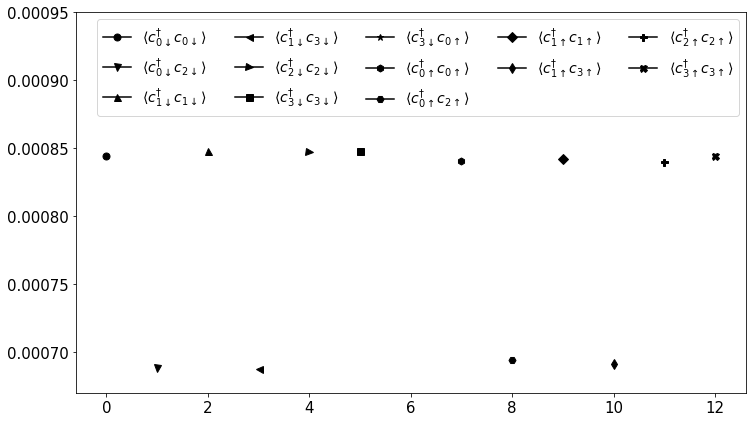

In [269]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,figsize=(12,7))
marker_arr=['o', 'v', '^', '<', '>','s','*','h', 'H', 'D', 'd', 'P','X']
ax.tick_params(labelsize=15)
ax.set_ylim([0.00067,0.00095])
d=['uparrow','downarrow']
for i in range(len(non_zero_dm_elems)):
    ax.plot(i,dm_err[i],label=r'$\langle c^{\dagger}_{%s\%s}c_{%s\%s}\rangle$'%(non_zero_dm_elems[i][0]%4,d[int(non_zero_dm_elems[i][0]<4)],non_zero_dm_elems[i][1]%4,d[int(non_zero_dm_elems[i][1]<4)]),marker=marker_arr[i],color='k',markersize=7,markeredgewidth=1)
plt.legend(ncol=5,fontsize=14)
plt.savefig('density_matrix_error.png')